# SVM

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt # graphs
import matplotlib.colors as colors

import joblib
import datetime

from collections import defaultdict

import sklearn
#from sklearn.utils import resample # downsample dataset
from sklearn.model_selection import train_test_split # split to training and testing datasets
from sklearn.model_selection import GridSearchCV # cross validation
#from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # support vector classifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

### Import data

We work with 1956 comments from 5 different YouTube videos. The [YouTube Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection#) is freely available.

In [2]:
path = r"data/YouTube-Spam-Collection/"
files = glob.glob(os.path.join(path, "*.csv"))

corpus = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
corpus.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [3]:
assert len(corpus) == 1956

In [4]:
"""nltk.download("punkt")
nltk.download("stopwords")
nltk.download('omw-1.4')
nltk.download("wordnet")"""

'nltk.download("punkt")\nnltk.download("stopwords")\nnltk.download(\'omw-1.4\')\nnltk.download("wordnet")'

### Statistics about the data

Data types:
COMMENT_ID    object
AUTHOR        object
DATE          object
CONTENT       object
CLASS          int64
dtype: object

There are 2 comment types: [1 0]
The dataset contains of 1956 examples: 1005 spam and 951 legitimate comments


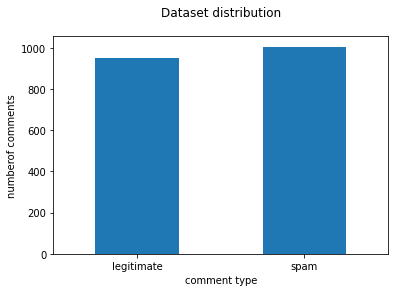

In [5]:
print(f"Data types:\n{corpus.dtypes}\n")
print(f"There are {len(corpus['CLASS'].unique())} comment types: {corpus['CLASS'].unique()}")
print(f"The dataset contains of {len(corpus)} examples: {len(corpus.loc[corpus['CLASS'] == 1])} spam and {len(corpus.loc[corpus['CLASS'] == 0])} legitimate comments")

corpus.groupby("CLASS").CONTENT.count().plot.bar(ylim=0)
plt.xticks([0,1],['legitimate', 'spam'], rotation=0)
plt.xlabel("comment type")
plt.ylabel("numberof comments")
plt.title("Dataset distribution", pad=20)
plt.show()

### Peprocessing

In [6]:
#nltk.download('stopwords')
#nltk.download('omw-1.4')
    
def preprocess_data(corpus,
                    irrelevant_features=["COMMENT_ID", "AUTHOR", "DATE"],
                    #rename_columns={"CONTENT":"COMMENT"}
                   ):
    
    # drop irrelevant features
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # remove blank rows if any
    corpus.dropna()
    
    # add column for representation
    corpus['REPR'] = corpus.loc[:, 'CONTENT']
        
    # lower case
    corpus['REPR'] = corpus['REPR'].str.lower()

    # change column name
    #for old, new in rename_columns:
        #corpus.rename({old : new}, axis=1, inplace=True)

    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    
    for comment in corpus["REPR"]:    
        comment = nltk.word_tokenize(comment) # tokenizing nltk.WordPunctTokenizer().tokenize(comment.lower())?
        comment = [lemmatizer.lemmatize(word) for word in comment] # lemmatizing
        comment = [word for word in comment if word not in stop_words] # removing stopwords
        comment = " ".join(comment)

In [7]:
preprocess_data(corpus)

# binary feature representation
vectorizer = CountVectorizer(binary=True, max_df=0.95) #max_features=10000, tokenizer=lambda doc: doc)
BOW = vectorizer.fit_transform(corpus["REPR"])

# count based feature representation
vectorizer_2 = CountVectorizer(binary=False, max_df=0.95) #max_features=10000)
BOW_2 = vectorizer_2.fit_transform(corpus["REPR"])

# bag of 2-Grams
bigram_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2])
BOW_3 = bigram_vectorizer.fit_transform(corpus["REPR"])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95) #min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
tfidf_voc = tfidf_vectorizer.fit_transform(corpus["REPR"])

### Support Vector Machine Classifier

### Train a SVM, save the model and report the classification performance

In [8]:
def split_data(features, labels):
    return train_test_split(features,labels, test_size=0.3,random_state=42,shuffle=True)


def save_model(model):
    now = datetime.datetime.now()
    model_output_path = "saved_models/"+model.__class__.__name__.lower()+"_"+str(now.minute)+"-"+str(now.second)+".joblib"
    joblib.dump(model, open(model_output_path, 'wb+'))


def report(model, best_model, X_test, y_test, labels):
    print(f"Best parameters set {model.best_params_} with accuracy {model.best_score_}")
    y_predict = best_model.predict(X_test)
    
    labels = sorted(list(set(labels)))
    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test, y_predict, labels=labels) # lables=clf.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    print("\nClassification report:")
    print(classification_report(y_test, y_predict))
    
    print("\nAccuracy: {}%".format(accuracy_score(y_test, y_predict)*100))
    print("Precision: {}%".format(sklearn.metrics.precision_score(y_test, y_predict)*100))
    print("Recall: {}%".format(sklearn.metrics.recall_score(y_test, y_predict)*100))

    
def train_svm_classifier(features, labels):
    # split data
    X_train, X_test, y_train, y_test = split_data(features, labels)

    param = {'C': [0.1, 1, 10, 100, 1000],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
             'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
            }

    clf = GridSearchCV(SVC(), param, cv=5, n_jobs=2, verbose=0)

    clf.fit(X_train, y_train)
    svm_clf = clf.best_estimator_
    
    # save model to disk
    save_model(svm_clf)
    
    # show test report
    report(clf, svm_clf, X_test, y_test, labels)

Best parameters set {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'} with accuracy 0.9532499131039277

Confusion matrix:


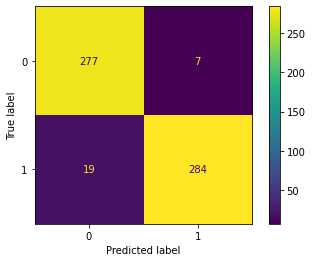


Classification report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       284
           1       0.98      0.94      0.96       303

    accuracy                           0.96       587
   macro avg       0.96      0.96      0.96       587
weighted avg       0.96      0.96      0.96       587


Accuracy: 95.57069846678023%
Precision: 97.59450171821305%
Recall: 93.72937293729373%


In [9]:
train_svm_classifier(BOW, np.asarray(corpus["CLASS"]))

Best parameters set {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'} with accuracy 0.9547177882944305

Confusion matrix:


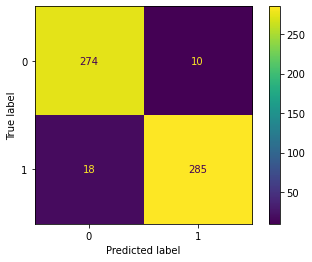


Classification report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       284
           1       0.97      0.94      0.95       303

    accuracy                           0.95       587
   macro avg       0.95      0.95      0.95       587
weighted avg       0.95      0.95      0.95       587


Accuracy: 95.22998296422487%
Precision: 96.61016949152543%
Recall: 94.05940594059405%


In [10]:
train_svm_classifier(BOW_2, np.asarray(corpus["CLASS"]))

Best parameters set {'C': 0.1, 'gamma': 1, 'kernel': 'linear'} with accuracy 0.9357316649287453

Confusion matrix:


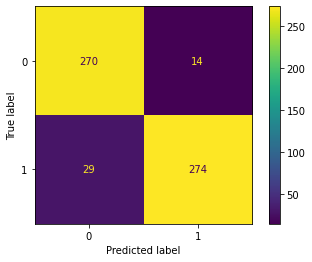


Classification report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       284
           1       0.95      0.90      0.93       303

    accuracy                           0.93       587
   macro avg       0.93      0.93      0.93       587
weighted avg       0.93      0.93      0.93       587


Accuracy: 92.67461669505963%
Precision: 95.13888888888889%
Recall: 90.42904290429043%


In [11]:
train_svm_classifier(BOW_3, np.asarray(corpus["CLASS"]))

Best parameters set {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'} with accuracy 0.9510735007085371

Confusion matrix:


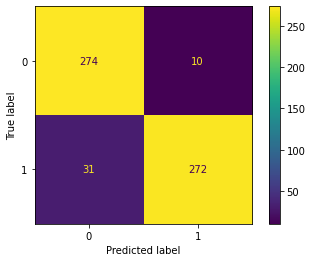


Classification report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       284
           1       0.96      0.90      0.93       303

    accuracy                           0.93       587
   macro avg       0.93      0.93      0.93       587
weighted avg       0.93      0.93      0.93       587


Accuracy: 93.01533219761498%
Precision: 96.45390070921985%
Recall: 89.76897689768977%


In [12]:
train_svm_classifier(tfidf_voc, np.asarray(corpus["CLASS"]))